In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import glob
from pathlib import Path

## Number of neighbors

Check how the result of the manifold sculpting depends on the number of neighbors used. Compare with other popular algorithms.

In [13]:
data_folder = Path('../data/results/neighbors/')
figures_folder = Path('../figs/SwissRoll/')
dataset2d_path = Path('../data/datasets/2d/N_2000.npy')

if not data_folder.exists():
    raise FileNotFoundError(f"Data folder {data_folder} does not exist. Please provide a valid dataset path.")

figures_folder.mkdir(parents=True, exist_ok=True)

if not dataset2d_path.exists():
    raise FileNotFoundError(f"Dataset 2D file {dataset2d_path} does not exist. Please provide a valid dataset path.")


isomap_files = sorted(data_folder.glob('Isomap_[0-9][0-9].npy'), key=lambda x: int(x.stem.split('_')[1]))
lle_files = sorted(data_folder.glob('LLE_[0-9][0-9].npy'), key=lambda x: int(x.stem.split('_')[1]))
ms_files = sorted(data_folder.glob('MS_[0-9][0-9].npy'), key=lambda x: int(x.stem.split('_')[1]))
times_files = list(data_folder.glob('*_time.npy'))

n_neighbors = [20, 28, 40, 57, 80]

### Time comparison

Check how much time is required to complete the calculation.

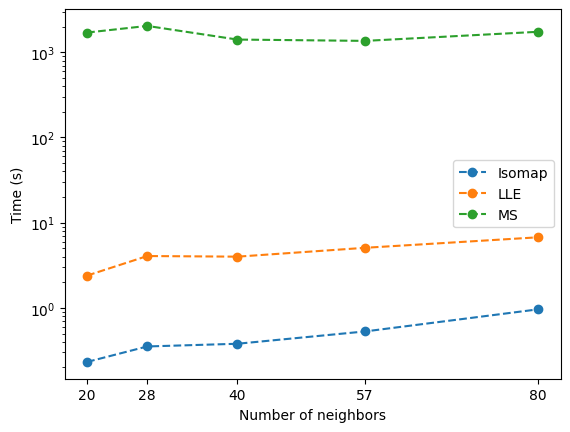

In [14]:
isomap_times = np.loadtxt(times_files[0])
lle_times = np.loadtxt(times_files[1])
ms_times = np.loadtxt(times_files[2])

labels = ['Isomap', 'LLE', 'MS']

for i, file in enumerate(times_files):
    data = np.loadtxt(file)
    plt.semilogy(n_neighbors, data, label=labels[i], marker='o', linestyle='--')

plt.xlabel('Number of neighbors')
plt.ylabel('Time (s)')
plt.xticks(n_neighbors)
plt.legend()
plt.show()

In [15]:
def pca(data):
    covariance_matrix = np.cov(data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    return sorted_eigenvalues, sorted_eigenvectors

for file in ms_files:
    X_ms = np.loadtxt(file)

    X_ms -= np.mean(X_ms, axis=0)
    eigenvals, eigenvecs = pca(X_ms)
    axis_point = np.array([0, 0, 0])
    axis_direction = np.array([0, 0, 1])
    theta = 0

    rotation_matrix = np.eye(3)
    rotation_matrix[:, :2] = eigenvecs[:, :2]

    # Rotate the data
    rotated_dataset = X_ms @ rotation_matrix

    # np.savetxt(data_folder + 'MS_rotated_' + str(n_neighbors[i]) + '.npy', rotated_dataset)

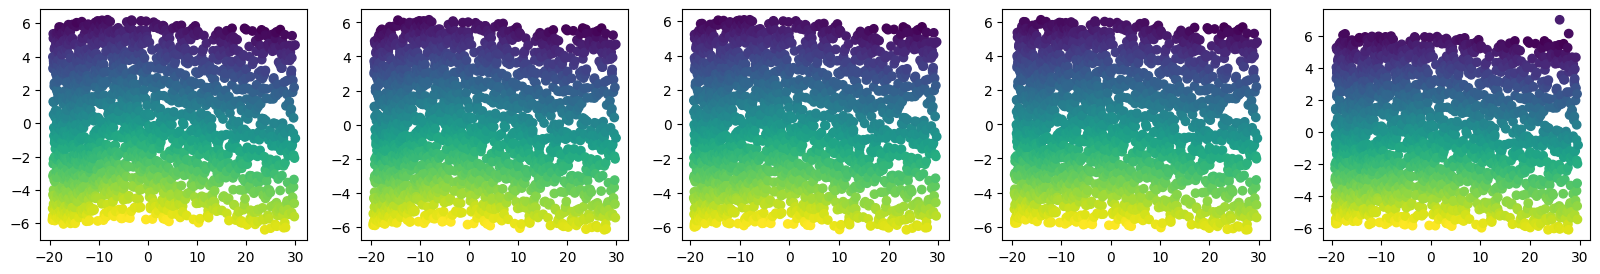

In [16]:
ms_files_rot = sorted(data_folder.glob('MS_rotated_[0-9][0-9].npy'), key=lambda x: int(x.stem.split('_')[2]))

fig, axs = plt.subplots(1, 5, figsize=(20, 3))

for i, file in enumerate(ms_files_rot):
    X_ms = np.loadtxt(file)
    if i == 1:
        X_ms[:, 0] = X_ms[:, 0] * -1
    if i == 3:
        X_ms[:, 1] = X_ms[:, 1] * -1
    axs[i].scatter(X_ms[:, 0], X_ms[:, 1], c=X_ms[:, 2], label='MS ' + str(n_neighbors[i]))

In [17]:
mse_isomap = np.zeros(len(isomap_files))
mse_lle = np.zeros(len(lle_files))
mse_ms = np.zeros(len(ms_files))

X_2D_scal = np.load(dataset2d_path)

X_2D_scal = minmax_scale(X_2D_scal)

for i in range(len(isomap_files)):

    X_isomap = np.loadtxt(isomap_files[i])
    X_lle = np.loadtxt(lle_files[i])
    X_ms = np.loadtxt(ms_files_rot[i])

    X_isomap_scal = X_isomap
    X_lle_scal = X_lle
    X_ms_scal = X_ms

    X_isomap_scal[:, 1] = X_isomap_scal[:, 1] * -1

    if i == 1:
        X_ms[:, 0] = X_ms[:, 0] * -1
        X_lle_scal[:, 0] = X_lle_scal[:, 0] * -1

    if i == 2:
        X_lle_scal[:, 0] = X_lle_scal[:, 0] * -1

    if i == 3:
        X_ms[:, 1] = X_ms[:, 1] * -1
        X_lle_scal[:, 1] = X_lle_scal[:, 1] * -1
        X_lle_scal[:, 0] = X_lle_scal[:, 0] * -1
    
    if i == 4:
        X_lle_scal[:, 1] = X_lle_scal[:, 1] * -1
        X_lle_scal[:, 0] = X_lle_scal[:, 0] * -1

    X_isomap_scal = minmax_scale(X_isomap_scal)
    X_lle_scal = minmax_scale(X_lle_scal)
    X_ms_scal = minmax_scale(X_ms_scal)


    fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

    ax[0, 0].scatter(X_2D_scal[:, 0], X_2D_scal[:, 1])
    ax[0, 0].set_title('Theorethocal')

    ax[0, 1].scatter(X_isomap_scal[:, 0], X_isomap_scal[:, 1])
    ax[0, 1].set_title('Isomap')

    ax[1, 0].scatter(X_lle_scal[:, 0], X_lle_scal[:, 1])
    ax[1, 0].set_title('LLE')

    ax[1, 1].scatter(X_ms_scal[:, 0], X_ms_scal[:, 1])
    ax[1, 1].set_title('MS')

    # plt.savefig(figures_folder + 'projection_' + str(n_neighbors[i]) + '.png')
    plt.close()

    mse_isomap[i] = mean_squared_error(X_2D_scal, X_isomap_scal)
    mse_lle[i] = mean_squared_error(X_2D_scal, X_lle_scal)
    mse_ms[i] = mean_squared_error(X_2D_scal, X_ms_scal[:, 0:2])


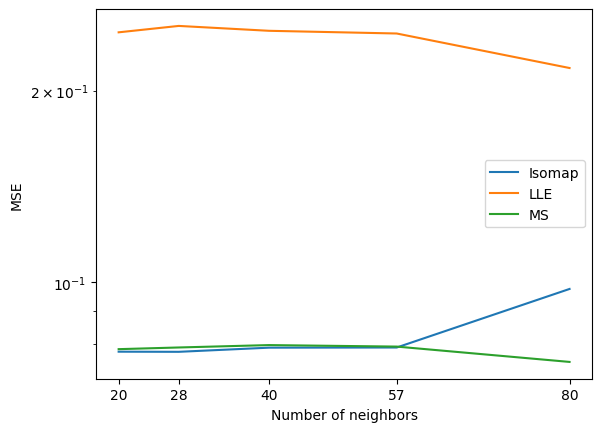

In [18]:
plt.semilogy(n_neighbors, mse_isomap, label='Isomap')
plt.semilogy(n_neighbors, mse_lle, label='LLE')
plt.semilogy(n_neighbors, mse_ms, label='MS')
plt.xticks(n_neighbors)
plt.xlabel('Number of neighbors')
plt.ylabel('MSE')
plt.legend()
# plt.savefig(figures_folder + 'MSE.png')
plt.show()

## Sizes

In [19]:
data_folder = Path('../data/results/sizes/')
dataset2d_folder = Path('../data/datasets/2d/')

if not data_folder.exists():
    raise FileNotFoundError(f"Data folder {data_folder} does not exist. Please provide a valid dataset path.")
if not dataset2d_folder.exists():
    raise FileNotFoundError(f"Dataset 2D folder {dataset2d_folder} does not exist. Please provide a valid dataset path.")

isomap_files = sorted(data_folder.glob('isomap_*.npy'), key=lambda x: int(x.stem.split('_')[1]))
lle_files = sorted(data_folder.glob('LLE_*.npy'), key=lambda x: int(x.stem.split('_')[1]))
ms_files = sorted(data_folder.glob('MS_[0-9][0-9]*.npy'), key=lambda x: int(x.stem.split('_')[1]))



X_2D_files = sorted(dataset2d_folder.glob('N_*.npy'), key=lambda x: int(x.stem.split('_')[1]))
if not X_2D_files:
    raise FileNotFoundError(f"No 2D dataset files found in {dataset2d_folder}. Please provide a valid dataset path.")

sizes = [250, 500, 1000]

In [20]:
order = [1, 2, 0]

In [21]:
for size in sizes:
    X_ms = np.loadtxt(data_folder / f'MS_{size}.npy')

    X_ms -= np.mean(X_ms, axis=0)
    eigenvals, eigenvecs = pca(X_ms)
    axis_point = np.array([0, 0, 0])
    axis_direction = np.array([0, 0, 1])
    theta = 0

    rotation_matrix = np.eye(3)
    rotation_matrix[:, :2] = eigenvecs[:, :2]

    # Rotate the data
    rotated_dataset = X_ms @ rotation_matrix

    # np.savetxt(data_folder + 'MS_rotated_' + str(size) + '.npy', rotated_dataset)

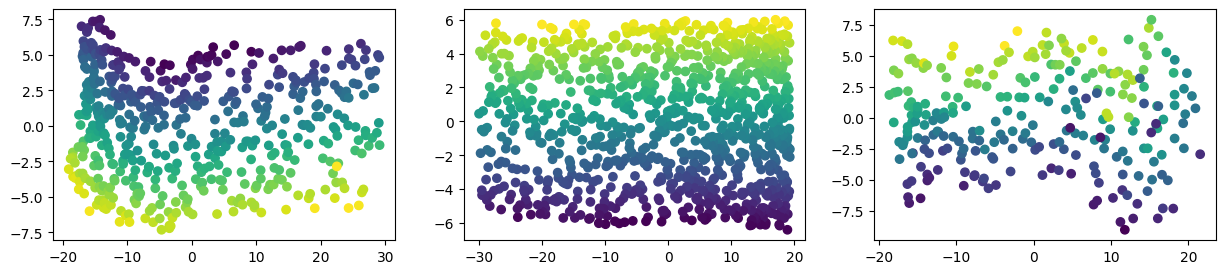

In [22]:
ms_files_rot = sorted(Path(data_folder).glob('MS_rotated_[0-9][0-9]*.npy'), key=lambda x: int(x.stem.split('_')[2]))

fig, axs = plt.subplots(1, 3, figsize=(15, 3))

for i, index in enumerate(order):
    X_ms = np.loadtxt(ms_files_rot[index])
    if i== 2:
        X_ms[:, 0] = X_ms[:, 0] * -1
        X_ms[:, 1] = X_ms[:, 1] * -1
    axs[i].scatter(X_ms[:, 0], X_ms[:, 1], c=X_ms[:, 2], label='MS ' + str(n_neighbors[i]))

In [23]:
mse_isomap = np.zeros(len(isomap_files))
mse_lle = np.zeros(len(lle_files))
mse_ms = np.zeros(len(ms_files))

for j, i in enumerate(order):

    X_isomap = np.loadtxt(isomap_files[i])
    X_lle = np.loadtxt(lle_files[i])
    X_ms = np.loadtxt(ms_files_rot[i])

    X_2D_scal = np.load(dataset2d_folder / f"N_{str(sizes[j])}.npy")
    X_2D_scal = minmax_scale(X_2D_scal)

    X_isomap_scal = X_isomap
    X_lle_scal = X_lle
    X_ms_scal = X_ms

    X_isomap_scal[:, 1] = X_isomap_scal[:, 1] * -1

    if i == 0:
        X_ms[:, 0] = X_ms[:, 0] * -1

    X_isomap_scal = minmax_scale(X_isomap_scal)
    X_lle_scal = minmax_scale(X_lle_scal)
    X_ms_scal = minmax_scale(X_ms_scal)


    fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

    ax[0, 0].scatter(X_2D_scal[:, 0], X_2D_scal[:, 1])
    ax[0, 0].set_title('Theorethocal')

    ax[0, 1].scatter(X_isomap_scal[:, 0], X_isomap_scal[:, 1])
    ax[0, 1].set_title('Isomap')

    ax[1, 0].scatter(X_lle_scal[:, 0], X_lle_scal[:, 1])
    ax[1, 0].set_title('LLE')

    ax[1, 1].scatter(X_ms_scal[:, 0], X_ms_scal[:, 1])
    ax[1, 1].set_title('MS')

    # plt.savefig(figures_folder + f'projection_{sizes[j]}.png')
    plt.close()

    mse_isomap[i] = mean_squared_error(X_2D_scal, X_isomap_scal)
    mse_lle[i] = mean_squared_error(X_2D_scal, X_lle_scal)
    mse_ms[i] = mean_squared_error(X_2D_scal, X_ms_scal[:, 0:2])

# reorder

mse_isomap = mse_isomap[order]
mse_lle = mse_lle[order]
mse_ms = mse_ms[order]


ValueError: Found input variables with inconsistent numbers of samples: [250, 500]

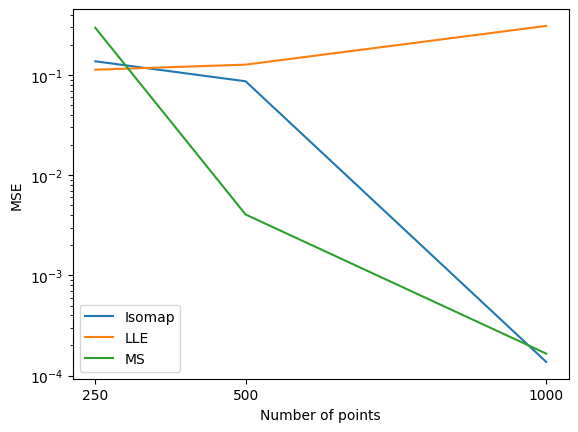

In [ ]:
plt.semilogy(sizes, mse_isomap, label='Isomap')
plt.semilogy(sizes, mse_lle, label='LLE')
plt.semilogy(sizes, mse_ms, label='MS')
plt.xticks(sizes)
plt.xlabel('Number of points')
plt.ylabel('MSE')
plt.legend()
# plt.savefig(figures_folder + 'MSE_sizes.png')
plt.show()

# Sigma

In [ ]:
data_folder = '../data/results_SwissRoll/scaleFactors/'

ms_files = np.sort(glob.glob(data_folder + 'MS_[0-9]*.npy'))

X_2D_files = np.sort(glob.glob('../data/SwissRoll2D/N_1000.npy'))

sigmas = [0.80, 0.85, 0.99]

ms_files

array(['../data/results_SwissRoll/scaleFactors/MS_0.npy',
       '../data/results_SwissRoll/scaleFactors/MS_1.npy',
       '../data/results_SwissRoll/scaleFactors/MS_2.npy'], dtype='<U47')

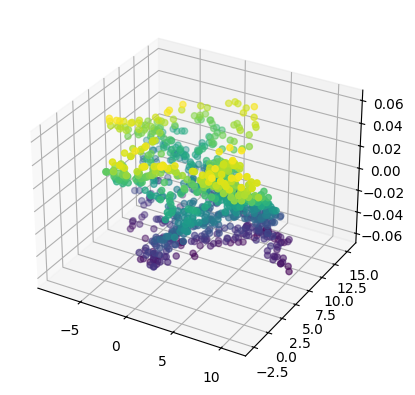

In [ ]:
data = np.loadtxt(ms_files[2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data[:, 2])

In [ ]:
for i in range(len(ms_files)):
    X_ms = np.loadtxt(ms_files[i])

    X_ms -= np.mean(X_ms, axis=0)
    eigenvals, eigenvecs = pca(X_ms)
    axis_point = np.array([0, 0, 0])
    axis_direction = np.array([0, 0, 1])
    theta = 0

    rotation_matrix = np.eye(3)
    rotation_matrix[:, :2] = eigenvecs[:, :2]

    # Rotate the data
    rotated_dataset = X_ms @ rotation_matrix

    np.savetxt(data_folder + 'MS_rotated_' + str(i) + '.npy', rotated_dataset)

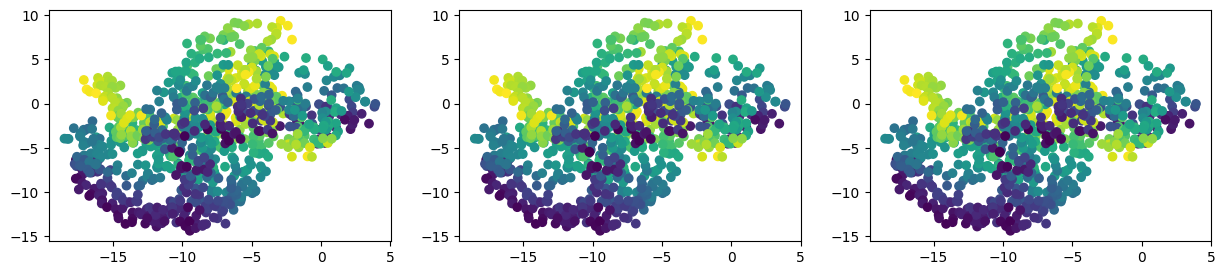

In [ ]:
ms_files_rot = np.sort(glob.glob(data_folder + 'MS_[0-9].npy'))

fig, axs = plt.subplots(1, 3, figsize=(15, 3))

for i, file in enumerate(ms_files_rot):
    X_ms = np.loadtxt(ms_files_rot[index])
    axs[i].scatter(X_ms[:, 0], X_ms[:, 1], c=X_ms[:, 2], label='MS ' + str(n_neighbors[i]))

# Checkpoints

In [ ]:
files_check = glob.glob('../data/SwissRoll_checkpoints/k20/checkpoint_*.npy')
files_check = np.sort(files_check)


dest_folder = '../figs/SwissRoll_checkpoints/k20/'

if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)


xlims = np.zeros(2)
ylims = np.zeros(2)
zlims = np.zeros(2)
for i, file in enumerate(files_check):
    X = np.load(file)
    X_max = np.max(X, axis=0)
    X_min = np.min(X, axis=0)

    for i in range(3):
        xlims[0] = min(xlims[0], X_min[i])
        xlims[1] = max(xlims[1], X_max[i])
        ylims[0] = min(ylims[0], X_min[i])
        ylims[1] = max(ylims[1], X_max[i])
        zlims[0] = min(zlims[0], X_min[i])
        zlims[1] = max(zlims[1], X_max[i])

print(xlims, ylims, zlims)

[-74.07702696  24.41352972] [-74.07702696  24.41352972] [-74.07702696  24.41352972]


In [ ]:
n_epochs = np.arange(10, 510, 10)
for i in n_epochs:
    file = f"../data/SwissRoll_checkpoints/k20/checkpoint_{i}.npy"

    X = np.load(file)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X[:, 1])

    # plt.savefig(dest_folder + f'checkpoint_{i:03d}.png')

    plt.close()